# Лабораторная работа №1: Цифровая обработка сигналов

Выполнил студент группы 9381 Колованов Родион, вариант 7.

## Цель работы

Изучить возможности библиотек Python для решения задач цифровой обработки сигналов.

## Задачи работы

1. Освоить Jupiter Notebook;
2. Выполнить загрузку аудио сигнала и построить огибающую;
3. Выбрать один из четырех типов фильтров и получить фильтрованный сигнал;
4. Реализовать амплитудный детектор сигнал/шум и получить сигнал после детектирования;
5. Реализовать эффект "Эхо" и получить сигнал после применения аудио-эффекта;
6. Реализовать эффект "Distortion" и получить сигнал после применения аудио-эффекта.

## Выполнение работы

### Загрузка аудиофайла

Для получения сигнала аудио-файла была использована библиотека wave. Для отрисовки графиков была использована библиотека matplotlib. Для воспроизведения измененного аудио-сигнала была использована библиотека IPython.

Для начала подключим нужные библиотеки:

In [168]:
import numpy as np
import scipy.signal as sig
import IPython.display as ipd
import matplotlib.pyplot as plt
import wave

Далее загрузим аудио-файл ***'data/03-01-05-01-01-01-01_A1.wav'*** и получим его аудио-сигнал:

In [169]:
filename = "data/03-01-05-01-01-01-01_A1.wav"

types = {
    1: np.int8,
    2: np.int16,
    4: np.int32
}

audiofile = wave.open(filename, "rb")
signal = np.frombuffer(audiofile.readframes(audiofile.getnframes()), types[audiofile.getsampwidth()])

print("Opened audio file '{}':".format(filename))

Opened audio file 'data/03-01-05-01-01-01-01_A1.wav':


Отобразим основную информацию об аудио-файле:

In [170]:
print("Channels:", audiofile.getnchannels())
print("Sample width:", audiofile.getsampwidth())
print("Frame rate:", audiofile.getframerate())
print("Frames:", audiofile.getnframes())
print("Compression type:", audiofile.getcomptype())
print("Compression name:", audiofile.getcompname())

Channels: 1
Sample width: 2
Frame rate: 48000
Frames: 185786
Compression type: NONE
Compression name: not compressed


Загруженный аудио-сигнал:

In [171]:
ipd.Audio(signal, rate=audiofile.getframerate())

Отобразим график аудио-сигнала:

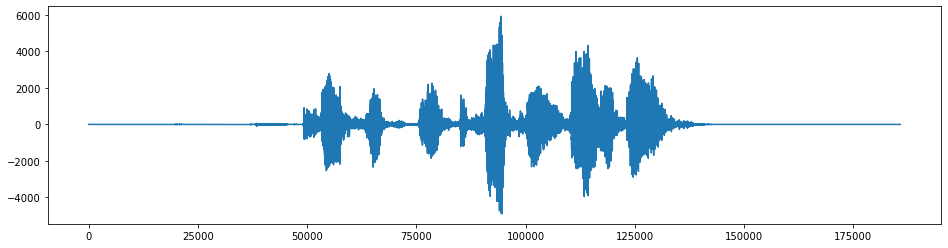

In [172]:
plt.figure(figsize=(16, 4))
plt.plot(signal)
plt.show()

### Построение огибающей аудио-сигнала

Пусть имеется сигнал $x(i)$, $i = 0, 1, \dots, N - 1$. Тогда огибающая $y(j)$, $j = 0, 1, \dots, n - 1$ вычисляется следующий образом:

$y(j) = \frac{1}{m} \cdot \sum_{k = m \cdot j}^{m (j + 1) - 1}|x(k)|$, где $m = [\frac{N}{n}]$ - число точек в интервале усреднения.

Вычислим огибающую:

In [173]:
def calculate_envelope(signal, envelope_length):
    signal_length = len(signal)
    frame_length = signal_length // envelope_length
    envelope = [0 for i in range(envelope_length)]

    for j in range(envelope_length):
        a = frame_length * j
        b = frame_length * (j + 1)
        envelope[j] = np.sum(np.abs(signal[a:b])) / frame_length
    
    return envelope

envelope_length = 400
envelope = calculate_envelope(signal, envelope_length)

Отобразим график аудио-сигнала и наложим на него график огибающей:

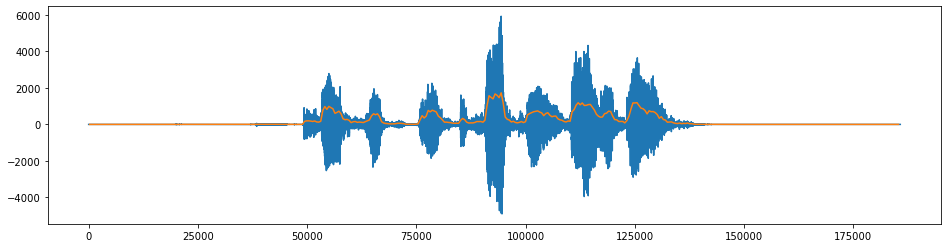

In [174]:
plt.figure(figsize=(16, 4))
plt.plot(signal)
plt.plot([frame_length * (i + 0.5) for i in range(envelope_length)], envelope)
plt.show()

### Фильтрация сигнала

В качестве типа фильтра был выбран ФНЧ (фильтр нижних частот).

Профильтруем аудио-сигнал:

In [175]:
def lowpass_filter(signal, order, slice_frequency):
    critical_frequency = 2 * slice_frequency / audiofile.getframerate()
    b, a = sig.butter(order, critical_frequency, "lowpass")
    return sig.filtfilt(b, a, signal)

order = 1
slice_frequency = 200
filtered_signal = lowpass_filter(signal, order, slice_frequency)

Профильтрованный аудио-сигнал:

In [176]:
ipd.Audio(filtered_signal, rate=audiofile.getframerate())

Отобразим график профильрованного аудио-сигнала и исходного аудио-сигнала:

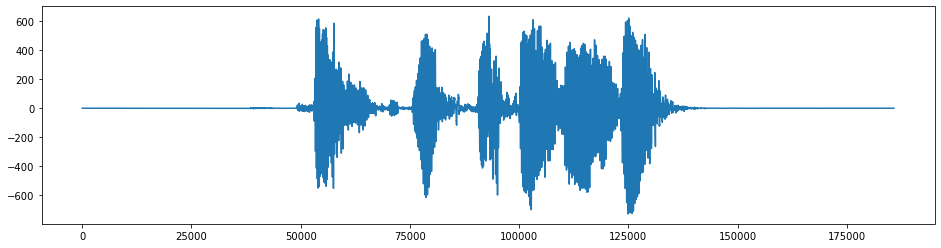

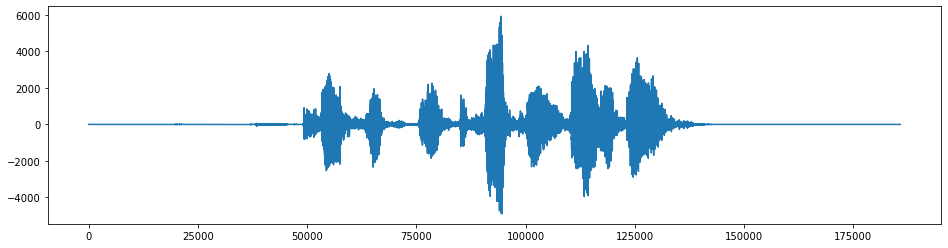

In [177]:
plt.figure(figsize=(16, 4))
plt.plot(filtered_signal)
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(signal)
plt.show()

### Реализация амплитудного детектора сигнал/шум

Детектор фиксирует начало сигнала, если значения сигнала по модулю в течении $k$ отсчетов превышает порог $Th$. Если же в течении $k$ отсчетов значения сигнала по модулю не превышает порог $Th$, то детектор фиксирует конец сигнала. В итоге детектированный сигнал $y(i)$ будет равен $x(i)$, если детектор фиксирует сигнал, иначе $y(i) = 0$.

Порог вычисляется, как $Th = \alpha \cdot mid$, где $mid = \frac{1}{N} \cdot \sum_{k = 0}^{N - 1}|x(k)|$, а $0 < \alpha < 1$ и выбирается экспериментально.

Пропустим исходный сигнал через детектор:

In [178]:
def calculate_middle_signal(signal):
    return np.sum(np.abs(signal)) / len(signal)

k = 100
alpha = 0.4
middle_signal = calculate_middle_signal(signal)
detector_threshold = middle_signal * alpha

def detect_signal(signal, detector_threshold):
    signal_length = len(signal)
    detected_signal = [0 for i in range(signal_length)]
    detected = False
    c1 = 0
    c2 = 0
    
    for i in range(signal_length):
        if detected:
            detected_signal[i] = signal[i]

        if np.abs(signal[i]) > detector_threshold:
            c1 += 1
            c2 = 0
        else:
            c1 = 0
            c2 += 1
        
        # Если количество подряд идущих сигналов, значение по модулю которых больше порога, больше k - то найдено начало сигнала
        if c1 >= k:
            detected = True
            for j in range(i - k + 1, i + 1):
                try:
                    detected_signal[j] = signal[j]
                except:
                    pass
        # Если количество подряд идущих сигналов, значение по модулю которых не превышает порога, больше k - то найден конец сигнала
        elif c2 >= k:
            detected = False
            for j in range(i - k + 1, i + 1):
                try:
                    detected_signal[j] = 0
                except:
                    pass
            
    return detected_signal
            
detected_signal = detect_signal(signal, detector_threshold)

Детектированный аудио-сигнал:

In [179]:
ipd.Audio(detected_signal, rate=audiofile.getframerate())

Отобразим график детектированного аудио-сигнала и исходного аудио-сигнала:

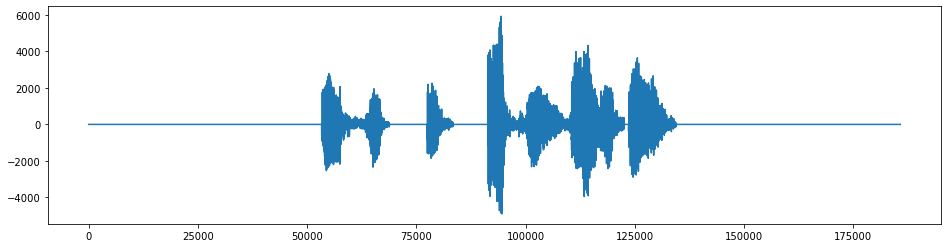

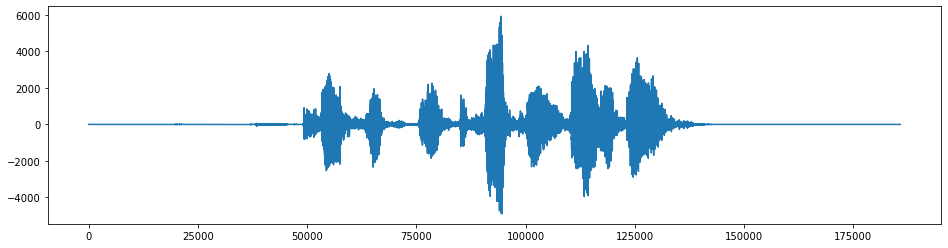

In [180]:
plt.figure(figsize=(16, 4))
plt.plot(detected_signal)
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(signal)
plt.show()

### Реализация эффекта "Эхо"

Простейший ревербератор, реализован как простой набор линий задержки. Каждая линия задержки имеет свой весовой коэффициент (количество линий задержки - $n$). Перед сложением исходного сигнала с сигналом ревербератора для получения требуемого эффекта необходимо сначала профильтровать выход ревербератора при помощи ФНЧ первого порядка, после чего домножить его на коэффициент применимости (задает соотношение между сухим и обработанным сигналом). Период времени в отсчетах между линиями задержки задается параметрами $D_1, \dots, D_n$.

Применим эффект "Эхо" на исходный сигнал:

In [181]:
def echo_effect(signal, applicability, delay_lines,  distance):
    sound_velocity = 335
    delay_1 = types[audiofile.getsampwidth()](2 * audiofile.getframerate() * distance / sound_velocity)
    delay_lines_length = len(delay_lines)
    delay_max = [delay_1]

    for i in range(2, delay_lines_length + 1):
        delay_max.append(types[audiofile.getsampwidth()](delay_1 * 2 ** ((1 - i) / delay_lines_length)))

    changed_signal = [0 for i in range(signal_length)]
    
    for i in range(signal_length):
        offset = 0
        for j in range(delay_lines_length):
            offset += delay_max[j]
            try:
                changed_signal[i + offset] += signal[i] * delay_lines[j]
            except:
                pass
    
    order = 1
    slice_frequency = 2000
    return lowpass_filter(changed_signal, order, slice_frequency) * applicability + signal

applicability = 0.5
delay_lines = [0.9, 0.45, 0.225, 0.1125, 0.055, 0.027, 0.013, 0.06]
distance = float(input("Введите расстояние до стены: "))
echo_signal = echo_effect(signal, applicability, delay_lines, distance)

Введите расстояние до стены: 15


Аудио-сигнал с эффектом "Эхо":

In [182]:
ipd.Audio(echo_signal, rate=audiofile.getframerate())

### Реализация эффекта "Distortion"

Пусть $x(i)$ - исходный сигнал, а $y(i)$ - сигнал после применения эффекта "Distortion", $i = 0, 1, \dots, N - 1$. Пользователем задается порог $Th$ и максимальное значение сигнала $Max$, $Th < Max$. Сигнал после применения эффекта считается следующим образом:

$y(i) = 
\begin{cases}
   x(i), &|x(i)| \le Th\\
   Max \cdot sign(x(i)), &|x(i)| > Th
\end{cases}
$

Применим эффект "Distortion" на исходный сигнал:

In [183]:
def distortion_effect(signal, threshold, max_amplitude):
    signal_length = len(signal)
    distortion_signal = [0 for i in range(signal_length)]

    for i in range(signal_length):
        if np.abs(signal[i]) > threshold:
            distortion_signal[i] = max_amplitude * (-1 if signal[i] < 0 else 1)
        else:
            distortion_signal[i] = signal[i]
    
    return distortion_signal

threshold = 1400
max_amplitude = 2000
distortion_signal = distortion_effect(signal, threshold, max_amplitude)

Аудио-сигнал с эффектом "Distortion":

In [184]:
ipd.Audio(distortion_signal, rate=audiofile.getframerate())

Отобразим график аудио-сигнала после применения эффекта и исходного аудио-сигнала:

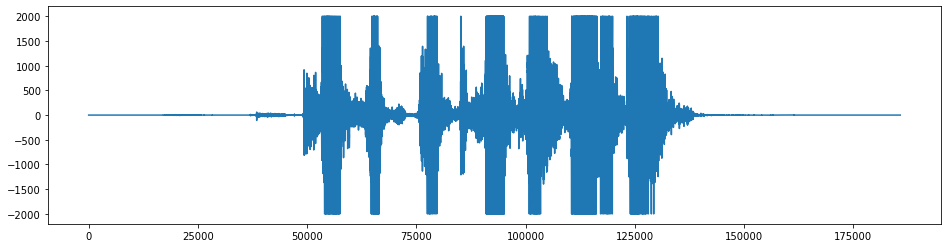

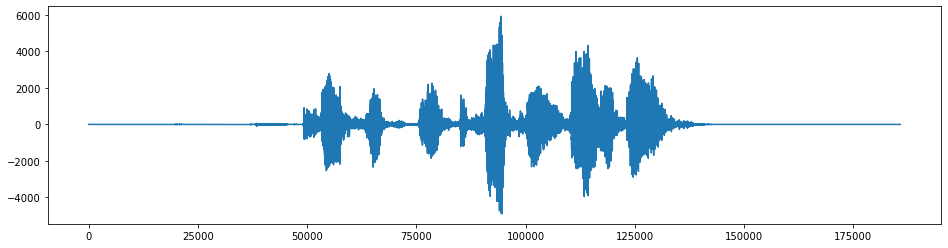

In [185]:
plt.figure(figsize=(16, 4))
plt.plot(distortion_signal)
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(signal)
plt.show()

## Выводы

Были изучены различные средства и библиотеки языка Python для решения задач цифровой обработки сигналов. В ходе лабораторной работы были получены навыки:
* Работы с *Jupiter Notebook* и $LaTeX$;
* Загрузки аудио-сигнала, построения огибающей и визуализации сигнала;
* Реализации алгоритмов обработки цифровых сигналов для решения задач фильтрации и детектирования;
* Реализации алгоритмов обработки цифровых сигналов для применения различных аудио-эффектов. 
